## **Introduction: Molecular modeling and simulation using Atomic Simulation Environment (ASE)**

Below steps outline a minimal working examples about ASE features

## 1. OPTIONAL 

### Create a virtual environment and install required packages. 

In [25]:
# Create a virtual environment using: python3 -m venv ~/.venv-ase-cp2k . Then pip3 install jupyterhub jupyterlab.
# Then open this notebook using jupyter-notebook NOTEBOOK.ipynb
#! pip3 install ase==3.25.0 mdanalysis==2.9.0
#! pip3 install nglview==3.1.4
#! pip3 install jupyter-ai[all]

### Install cp2k

In [26]:
# sudo apt-get install cp2k

## 2. Import Required Libraries

In [27]:
import os
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import molecule, add_adsorbate
from ase.io import write, read
from ase.visualize import view
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.nvtberendsen import NVTBerendsen
from ase import units
from ase.optimize import QuasiNewton, BFGS
from ase.io.trajectory import Trajectory
from ase.calculators.emt import EMT
from ase.calculators.cp2k import CP2K
from ase.build import fcc110, fcc100
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton

## 3. Molecular Modeling 

In [28]:
work_path = os.getcwd()

In [29]:
# Create benzene molecule
benzene = molecule('C6H6')
#benzene.rotate(90, 'x')
write("benzene.xyz", benzene)
nv.show_ase(benzene)
#view(benzene, viewer="ngl")

NGLWidget()

In [30]:
# create slabs
slab = fcc110('Cu', size=(8, 8, 4), vacuum=10.0) 
nv.show_ase(slab)


NGLWidget()

### Adsorption of Benzene on Copper, Silver, and Gold Surfaces J. Chem. Theory Comput. 2006, 2, 4, 1093–1105
### Favourable hollow site (between four copper atoms) and the long-bridge site (between two copper atoms)

In [31]:
# add adsorbate
benzene.rotate(90, 'x')
add_adsorbate(slab, benzene, position=(11,10), height=5)
slab_vth_benzene = slab 
nv.show_ase(slab_vth_benzene)
view(slab_vth_benzene, viewer="ngl")

## 4. Add Calculator to atoms (add software that you want to use)

In [32]:
#slab_vth_benzene.center(vacuum=5.0)
slab_vth_benzene.set_pbc([True, True, True])
slab_vth_benzene.calc = EMT()  # Basic All-atom force field based

# calc = CP2K(label='benzene',
#            cutoff=250,
#            basis_set='SZV-MOLOPT-GTH',
#            pseudo_potential='auto',
#            charge=0,
#            xc='PBE',
#            print_level='LOW',
#            max_scf=20)
#slab_vth_benzene.calc = calc

![Caclulators](https://https://ase-lib.org/_images/dftk.png)

In [33]:
## 5. Run Geometry Optimization

In [34]:
opt = BFGS(slab_vth_benzene, trajectory="optimized.traj", append_trajectory=False, logfile="opt.log")
energies = []

def print_status(a=slab_vth_benzene):
    epot = a.get_potential_energy()
    ekin = a.get_kinetic_energy()
    energies.append(epot+ekin)
    print(f' Energy | Epot = {epot:.3f} eV | Ekin = {ekin:.3f} eV | Etot = {epot+ekin:.3f} eV')

# One can attach functions to modify the output
opt.attach(print_status, interval=1)
print("Running optimization...")
opt.run(fmax=0.02, steps=20)
print("Simulation complete.")

# One can run MD 
#MaxwellBoltzmannDistribution(opt, temperature_K=300)
#mddyn_eql = NVTBerendsen(structure, timestep=0.5 * units.fs, temperature_K=300, taut=10 * units.fs, trajectory='equil.traj', logfile='equil.log', append_trajectory=True)

Running optimization...
 Energy | Epot = 118.498 eV | Ekin = 0.000 eV | Etot = 118.498 eV
 Energy | Epot = 100.254 eV | Ekin = 0.000 eV | Etot = 100.254 eV
 Energy | Epot = 95.104 eV | Ekin = 0.000 eV | Etot = 95.104 eV
 Energy | Epot = 92.769 eV | Ekin = 0.000 eV | Etot = 92.769 eV
 Energy | Epot = 91.656 eV | Ekin = 0.000 eV | Etot = 91.656 eV
 Energy | Epot = 91.116 eV | Ekin = 0.000 eV | Etot = 91.116 eV
 Energy | Epot = 90.773 eV | Ekin = 0.000 eV | Etot = 90.773 eV
 Energy | Epot = 90.646 eV | Ekin = 0.000 eV | Etot = 90.646 eV
 Energy | Epot = 90.590 eV | Ekin = 0.000 eV | Etot = 90.590 eV
 Energy | Epot = 90.505 eV | Ekin = 0.000 eV | Etot = 90.505 eV
 Energy | Epot = 90.428 eV | Ekin = 0.000 eV | Etot = 90.428 eV
 Energy | Epot = 90.388 eV | Ekin = 0.000 eV | Etot = 90.388 eV
 Energy | Epot = 90.367 eV | Ekin = 0.000 eV | Etot = 90.367 eV
 Energy | Epot = 90.341 eV | Ekin = 0.000 eV | Etot = 90.341 eV
 Energy | Epot = 90.314 eV | Ekin = 0.000 eV | Etot = 90.314 eV
 Energy | Ep

## 6. Post-Processing 

### Energy Profile

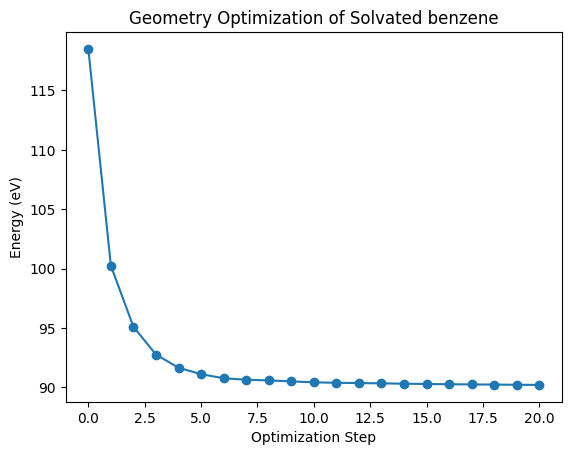

In [35]:
plt.figure()
plt.plot(range(len(energies)), energies, marker='o')
plt.xlabel('Optimization Step')
plt.ylabel('Energy (eV)')
plt.title('Geometry Optimization of Solvated benzene')
plt.savefig("optimization_energy.png")
plt.show()

### View geometry optimized trajectory 

In [37]:
frames = read('optimized.traj', index=':')
opt = Trajectory('optimized.traj')[-1]
opt.get_cell()
view(frames, viewer="ngl")


## 7. Why the effort? Why use ASE? 

1) Unified Python Interface
2) Supports many calculators/backends
3) Automation and Workflow control
4) Reusability
5) Built in optimization and dynamics
6) Strong Community 